In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int
from ff_energy.ffe.utils import pickle_output, PKL_PATH, read_from_pickle, str2int
from ff_energy.ffe.data import pairs_data, Data

In [2]:
p = PKL_PATH / "water_cluster/pbe0dz/pbe.pc"
data_tip3 = Data(p)

loading pickles from  /home/boittier/Documents/phd/ff_energy/pickles/water_cluster/pbe0dz/pbe.pc


In [3]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [6]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "pc_pbe0dz_clusters.ff.pkl"

In [7]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [8]:
# _c.data["ELEC"] = data_tip3.data["ELEC"]

In [9]:
_c.intE = "ECOL"
_c.set_targets()
_c

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [10]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [1047.7825811898601, 1998.0735242785038, 1339.9799000566748, 1689.737493941316, 248.73382583687254]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  205.83306884765625
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 205.83306884765625
             x: [ 1.001e+03  1.997e+03  1.304e+03  1.476e+03  3.130e+02]
           nit: 91
          nfev: 275
 final_simplex: (array([[ 1.001e+03,  1.997e+03, ...,  1.476e+03,
                         3.130e+02],
                       [ 1.001e+03,  1.997e+03, ...,  1.476e+03,
                         3.130e+02],
                       ...,
                       [ 1.001e+03,  1.997e+03, ...,  1.476e+03,
                         3.130e+02],
                       [ 1.001e+03,  1.997e+03, ...,  1.476e+03,
                         3.130e+02]]), array([ 2.058e+02,  2.058e+02,  2.058e+02,  2.058e+02,
                        2.058e+02,  2.058e+02]))


In [11]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([1001.35792294, 1996.82922024, 1303.55861768, 1476.48496741,
        312.96635   ])

In [12]:
np.sqrt(loss)

14.346884

In [13]:
# _c.eval_jax_chgpen(resx ) 

1.1292463382217392e-144


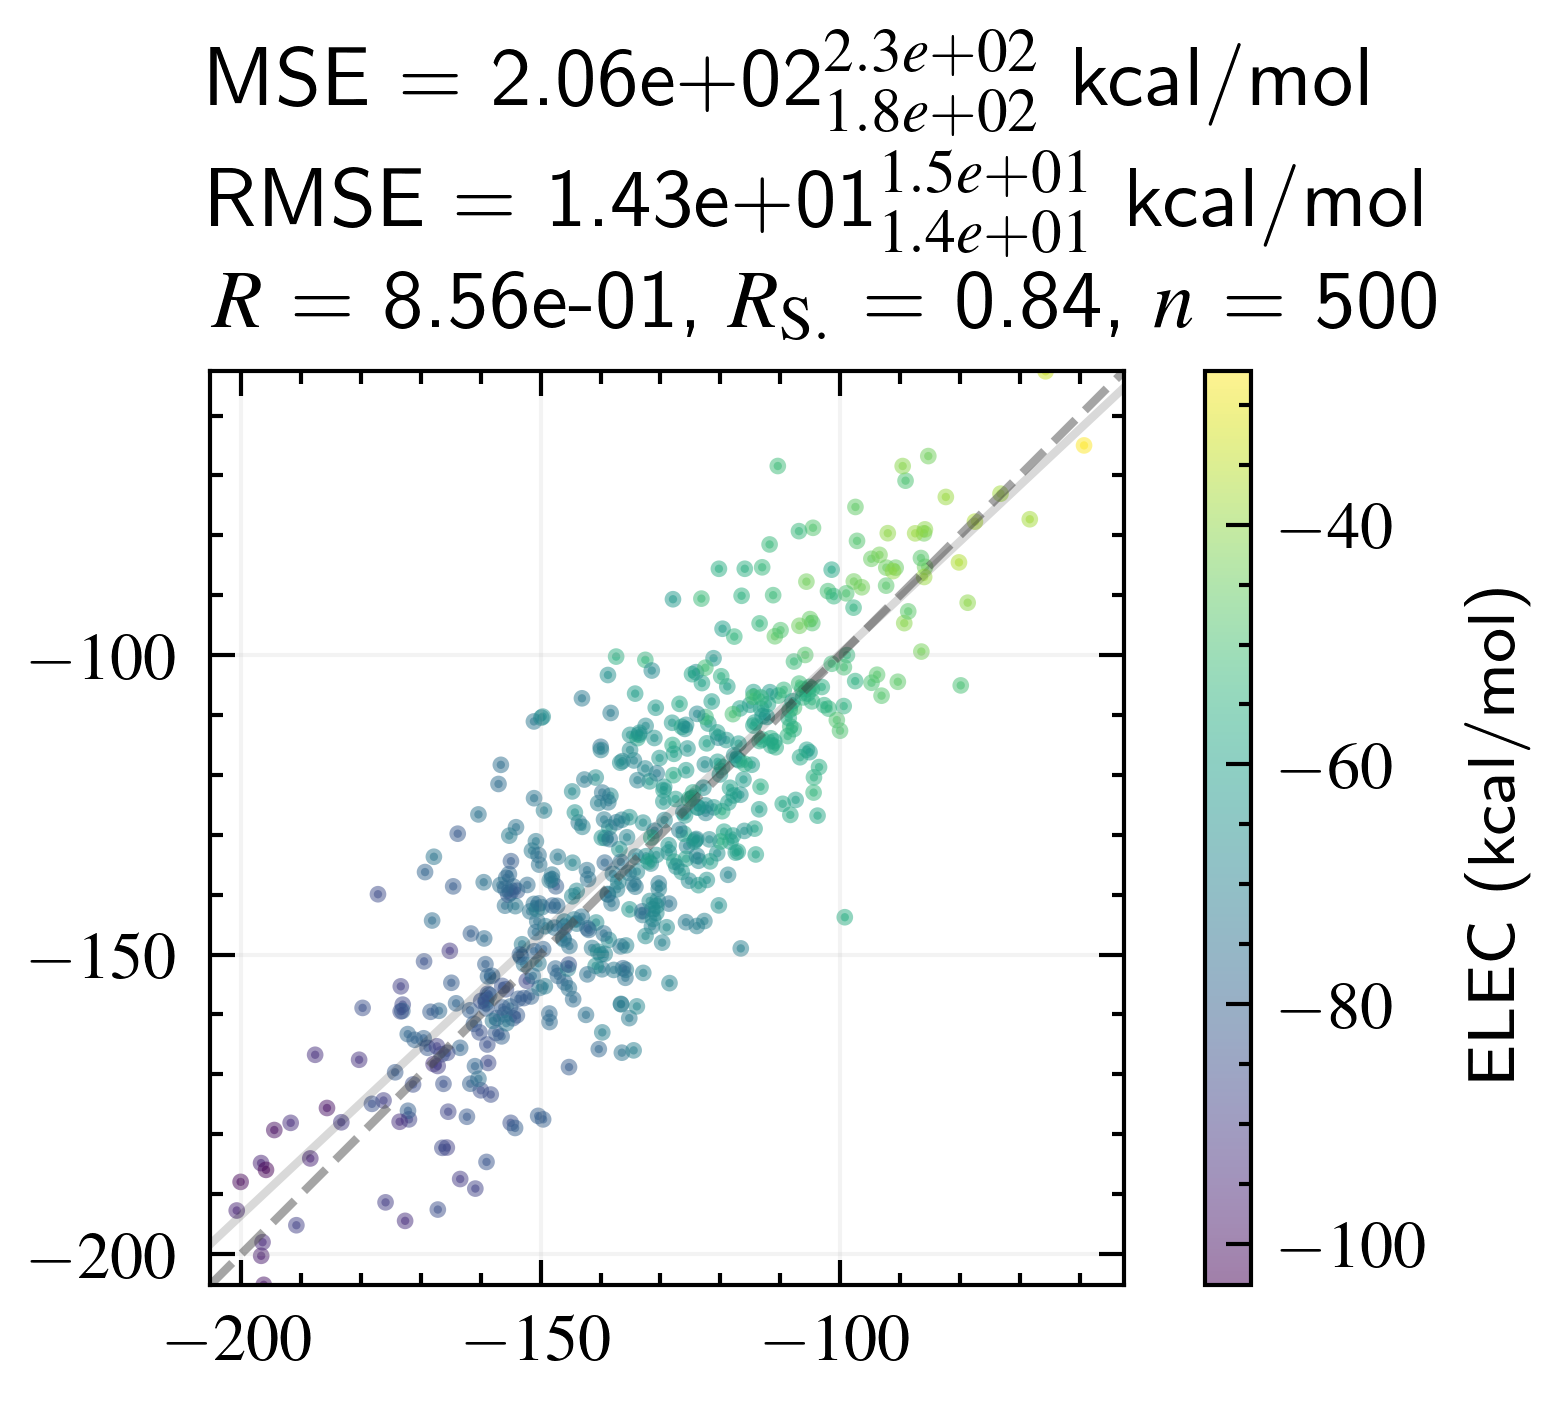

In [15]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")

plt.savefig("optpc_fit_ecol.pdf")

2.5608014994665487e-245


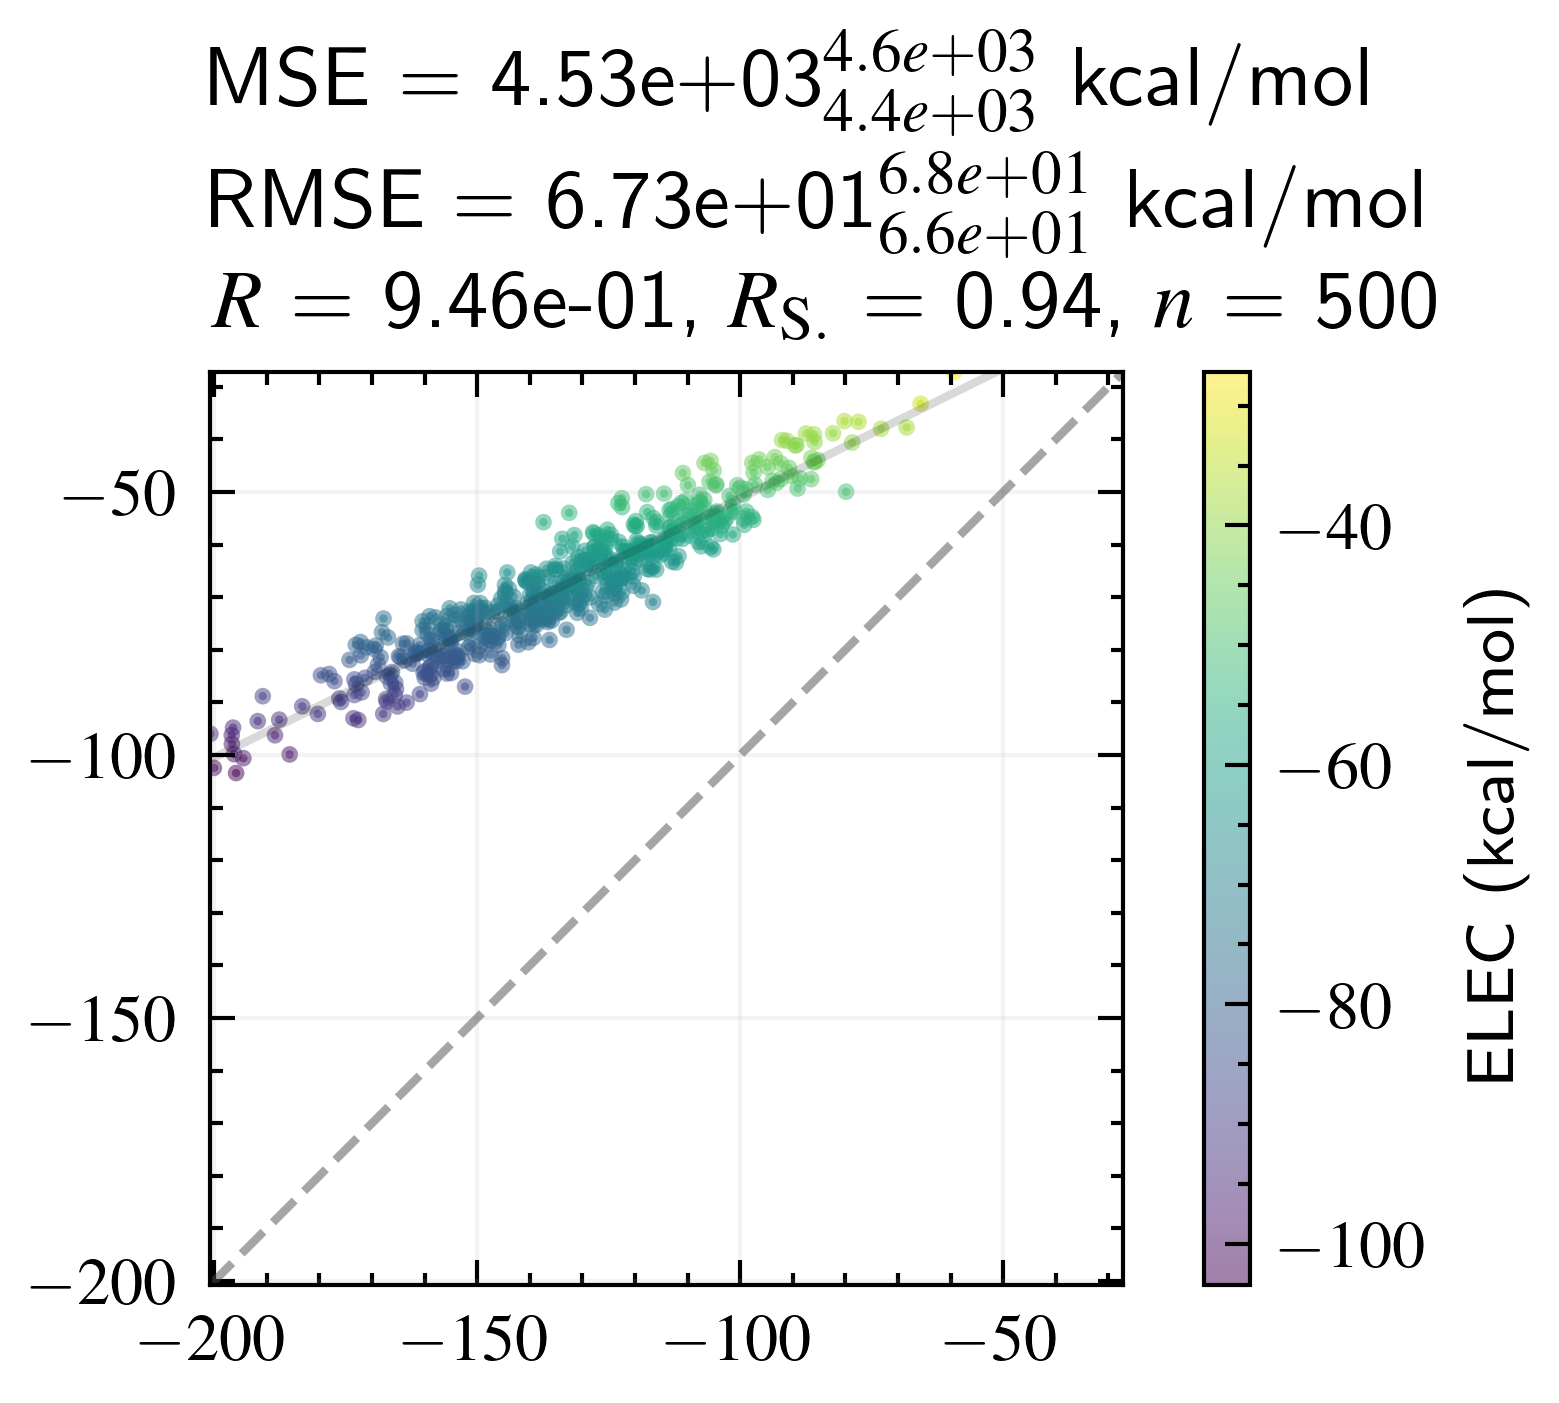

In [17]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")
plt.savefig("optpc_ecol.pdf")

In [18]:
_c.data["fit_ECOL"].mean()

-131.48485

In [19]:
pickle_output(_c, "ff/fit_ECOL_optpc_intE")

#  LJ fit


In [20]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))

In [21]:
LJFF.elec = "ELEC"
LJFF.intE = "intE"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

8.731063


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [22]:
fit_repeat(LJFF, 
           15, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [23]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
5,29.448702,230,441,0,True,Optimization terminated successfully.,"[0.001, 1.803987998142071, 2.5, 0.114666753652...","([[0.001, 1.803987998142071, 2.5, 0.1146667536..."
3,29.448708,442,752,0,True,Optimization terminated successfully.,"[0.001, 1.8039248131755858, 2.499999206909952,...","([[0.001, 1.8039248131755858, 2.49999920690995..."
6,29.448717,156,306,0,True,Optimization terminated successfully.,"[0.001, 1.803924840782508, 2.4996659537483303,...","([[0.001, 1.803924840782508, 2.499665953748330..."
8,29.448717,484,862,0,True,Optimization terminated successfully.,"[0.001, 1.804038218015588, 2.4999828153139383,...","([[0.001, 1.804038218015588, 2.499982815313938..."
4,29.701286,198,392,0,True,Optimization terminated successfully.,"[0.03441023265480349, 1.75006826239587, 0.6945...","([[0.03441023265480349, 1.75006826239587, 0.69..."
2,35.065056,148,300,0,True,Optimization terminated successfully.,"[0.09118776046621321, 2.213090192084529, 2.5, ...","([[0.09118776046621321, 2.213090192084529, 2.5..."
14,35.065056,190,362,0,True,Optimization terminated successfully.,"[0.09087348971066181, 2.2133118746290377, 2.5,...","([[0.09087348971066181, 2.2133118746290377, 2...."
9,55.648426,149,303,0,True,Optimization terminated successfully.,"[1.7607195532585975, 0.03414960473721622, 0.00...","([[1.7607195532585975, 0.03414960473721622, 0...."
1,129.745026,32,127,0,True,Optimization terminated successfully.,"[0.04321858732493396, 0.030716576770094678, 0....","([[0.04321858732493396, 0.030716576770094678, ..."
7,129.745026,53,168,0,True,Optimization terminated successfully.,"[0.025908061730752607, 0.001, 0.76609324433460...","([[0.025908061730752607, 0.001, 0.766093244334..."


In [24]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 1.80398800e+00, 2.50000000e+00, 1.14666754e-01])

In [25]:
abs(LJFF.eval_jax(bestres)).mean()

Array(8.770659, dtype=float32)

In [26]:
abs(LJFF.targets).mean()

Array(9.281264, dtype=float32)

In [27]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

5.4266658141551805

9.13764023739214e-207


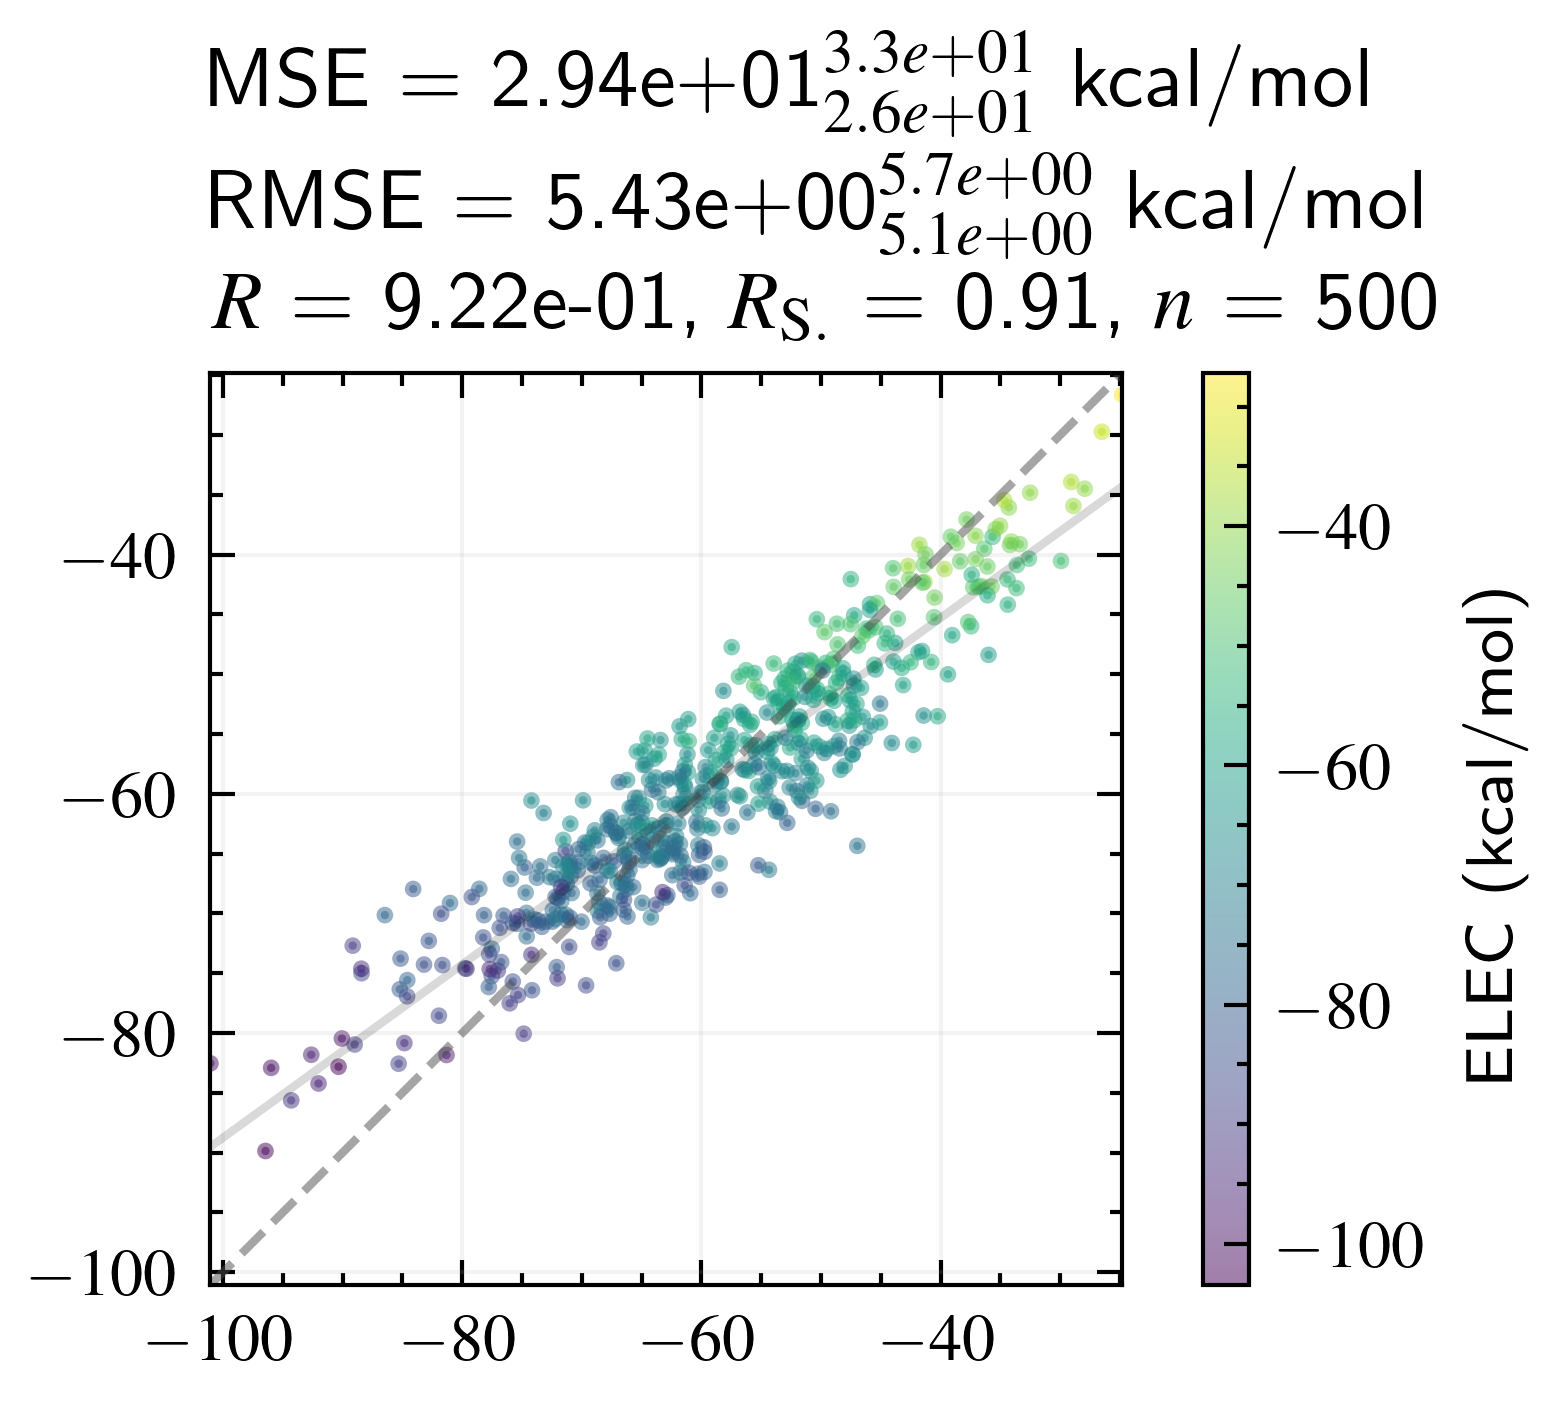

In [29]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("optpc_harmonic_lj_fit.pdf")


#  LJ fit exact


In [30]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [31]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [32]:
# data_.data

In [33]:
# data_.monomer_df

In [34]:
LJFF.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs,fit_ECOL
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917,-158.353302
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093,-105.305481
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225,-157.451599
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989,-115.803604
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749,-145.878052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665,-155.224197
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412,-129.201385
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865,-170.733978
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222,-141.909271


In [35]:
LJFF.elec = "ELEC"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

7.637727


FF: LJ water_cluster ELEC Exact intE (jax_coloumb: True)

In [36]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [37]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
4,29.981846,169,322,0,True,Optimization terminated successfully.,"[0.0010006215396097047, 1.7892066133678344, 2....","([[0.0010006215396097047, 1.7892066133678344, ..."
5,29.981886,312,556,0,True,Optimization terminated successfully.,"[0.001, 1.7892157199348602, 2.499430059134945,...","([[0.001, 1.7892157199348602, 2.49943005913494..."
2,30.192032,152,308,0,True,Optimization terminated successfully.,"[0.001, 1.7481727173432517, 1.0794118263545305...","([[0.001, 1.7481727173432517, 1.07941182635453..."
8,30.415728,238,454,0,True,Optimization terminated successfully.,"[0.09255348614999294, 1.7247233051841302, 0.32...","([[0.09255348614999294, 1.7247233051841302, 0...."
9,35.276657,364,664,0,True,Optimization terminated successfully.,"[1.4695075412623595, 0.9263268091914395, 0.002...","([[1.4695075412623595, 0.9263268091914395, 0.0..."
1,112.632027,33,124,0,True,Optimization terminated successfully.,"[0.001, 0.03150488092010603, 0.748173193266804...","([[0.001, 0.03150488092010603, 0.7481731932668..."
3,112.632027,46,166,0,True,Optimization terminated successfully.,"[0.001, 0.001, 1.5283594539342622, 2.5]","([[0.001, 0.001, 1.5283594539342622, 2.5], [0...."
6,112.632027,49,169,0,True,Optimization terminated successfully.,"[0.00351977885973076, 0.001, 0.245371439074498...","([[0.00351977885973076, 0.001, 0.2453714390744..."
7,112.632027,54,156,0,True,Optimization terminated successfully.,"[0.001, 0.001, 0.44199812521885995, 2.5]","([[0.001, 0.001, 0.44199812521885995, 2.5], [0..."
10,112.632027,44,152,0,True,Optimization terminated successfully.,"[0.024560300866612872, 0.001, 0.56787750537630...","([[0.024560300866612872, 0.001, 0.567877505376..."


In [38]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00062154e-03, 1.78920661e+00, 2.49999652e+00, 1.31512038e-01])

In [39]:
abs(LJFF.eval_jax(bestres)).mean()

Array(7.753261, dtype=float32)

In [40]:
abs(LJFF.targets).mean()

Array(8.48228, dtype=float32)

In [41]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

5.475568085204757

2.2207019959992733e-203


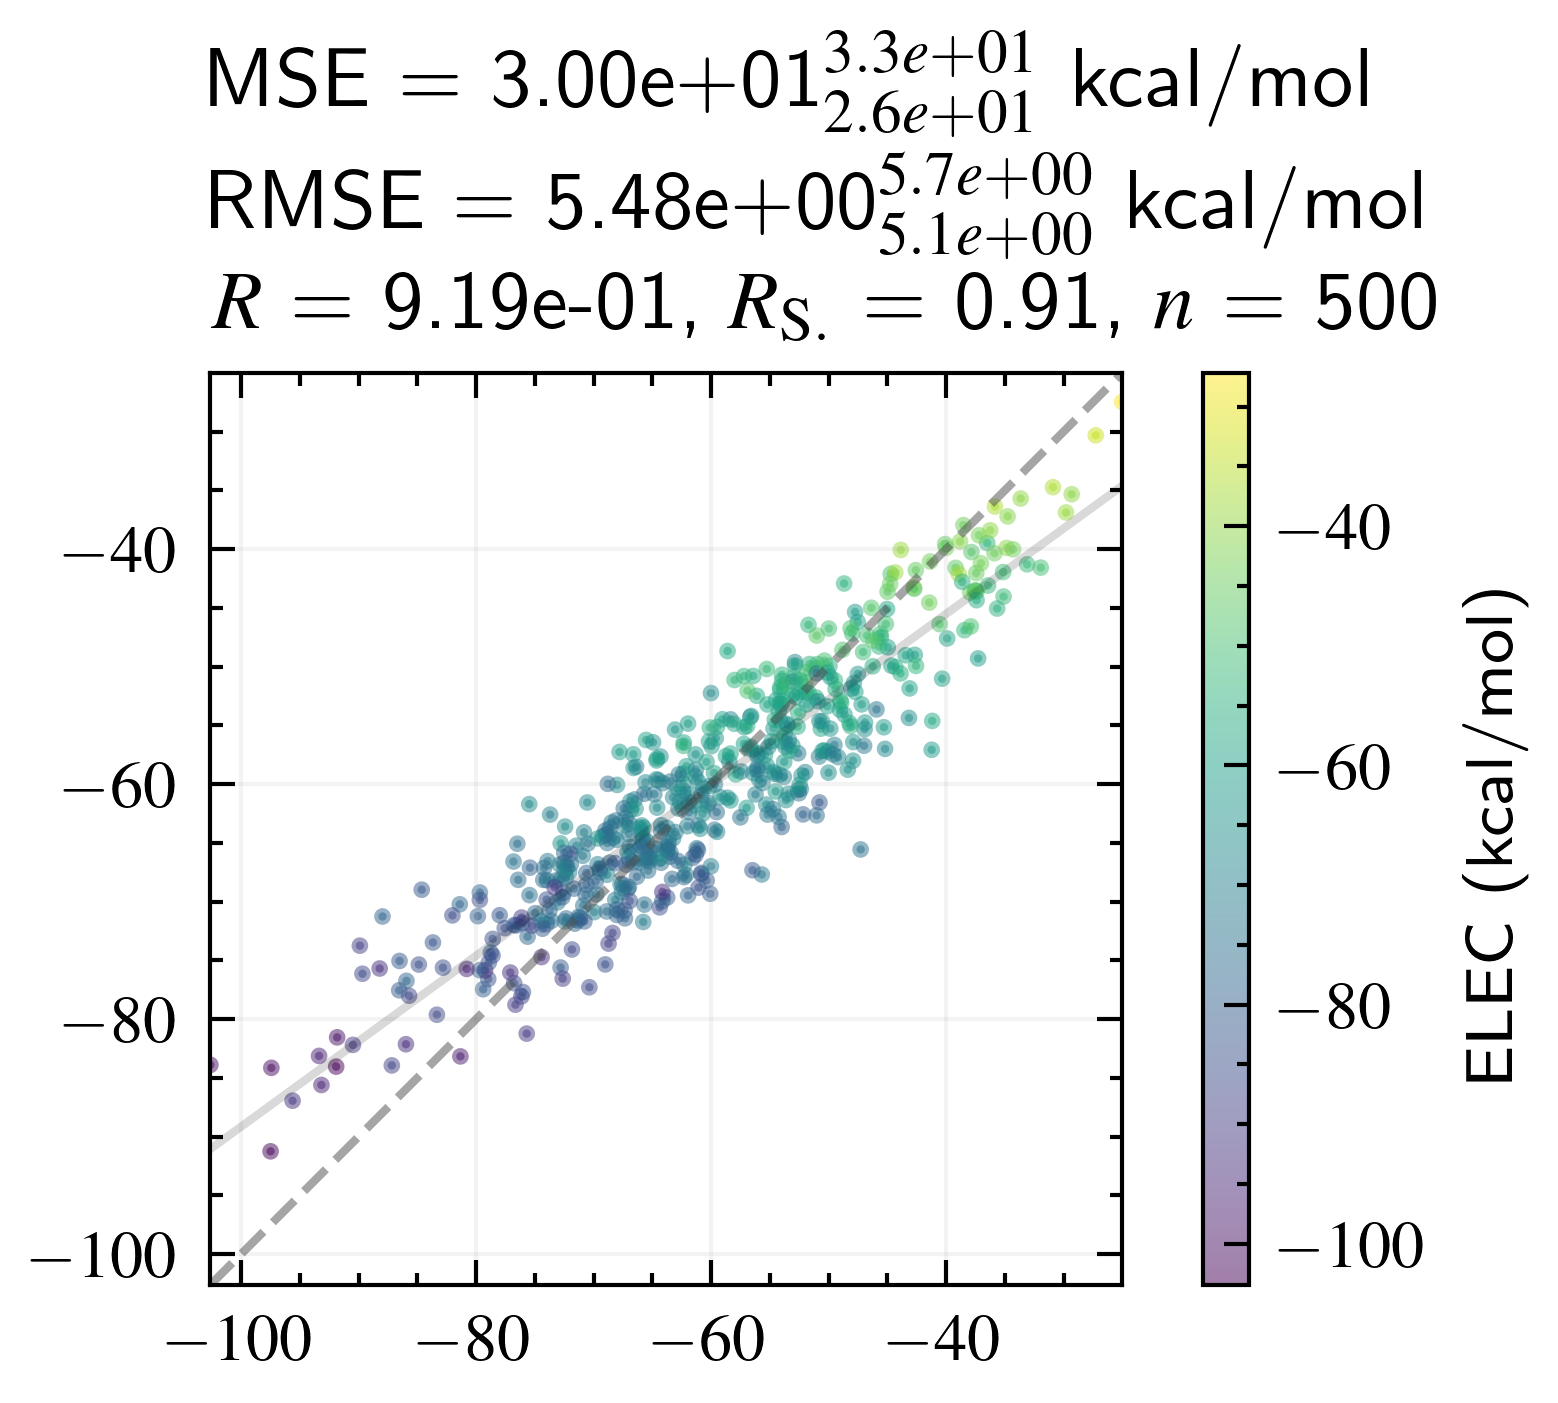

In [42]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("optpc_exact_lj_fit.pdf")


In [43]:
# LJFF.elec = "fit_ECOL"
# LJFF.intE = "intE"
# LJFF.set_intE()
# LJFF.set_targets()
# print(LJFF.targets.mean())
# LJFF

#  LJ fit exact, ECOL


In [44]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [45]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [46]:
# data_.data

In [47]:
# data_.monomer_df

In [48]:
# LJFF.data

In [49]:
LJFF.elec = "ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

73.60582


FF: LJ water_cluster ECOL Exact intE (jax_coloumb: True)

In [50]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [51]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
3,21.107992,366,667,0,True,Optimization terminated successfully.,"[0.45570808451952605, 2.190915155972755, 0.001...","([[0.45570808451952605, 2.190915155972755, 0.0..."
9,21.862564,414,734,0,True,Optimization terminated successfully.,"[0.001, 2.117501928226182, 0.001, 0.0351973816...","([[0.001, 2.117501928226182, 0.001, 0.03519738..."
5,21.902891,439,773,0,True,Optimization terminated successfully.,"[0.001, 2.169701576639674, 0.20117728453146078...","([[0.001, 2.169701576639674, 0.201177284531460..."
4,36.263618,337,632,0,True,Optimization terminated successfully.,"[0.001, 2.1209679380756494, 2.4233173504161147...","([[0.001, 2.1209679380756494, 2.42331735041611..."
1,111.179489,864,1477,0,True,Optimization terminated successfully.,"[1.7060842751007037, 1.9648550174771588, 0.001...","([[1.7060842751007037, 1.9648550174771588, 0.0..."
2,113.858932,618,1061,0,True,Optimization terminated successfully.,"[1.6149280735909182, 1.957401958475382, 0.0019...","([[1.6149280735909182, 1.957401958475382, 0.00..."
0,205.833069,91,275,0,True,Optimization terminated successfully.,"[1001.3579229369614, 1996.8292202356433, 1303....","([[1001.3579229369614, 1996.8292202356433, 130..."
6,5713.072266,47,159,0,True,Optimization terminated successfully.,"[0.001, 0.07316770537378081, 2.121259209848848...","([[0.001, 0.07316770537378081, 2.1212592098488..."
7,5713.072266,44,152,0,True,Optimization terminated successfully.,"[0.02024213045573254, 0.0689766628190226, 2.14...","([[0.02024213045573254, 0.0689766628190226, 2...."
8,5713.072266,56,179,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.5, 1.17027474646917]","([[0.001, 0.001, 2.5, 1.17027474646917], [0.00..."


In [52]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([4.55708085e-01, 2.19091516e+00, 1.00000000e-03, 2.09024398e-02])

In [53]:
abs(LJFF.eval_jax(bestres)).mean()

Array(73.61105, dtype=float32)

In [54]:
abs(LJFF.targets).mean()

Array(73.60582, dtype=float32)

In [55]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.594343497415187

8.97806387953783e-231


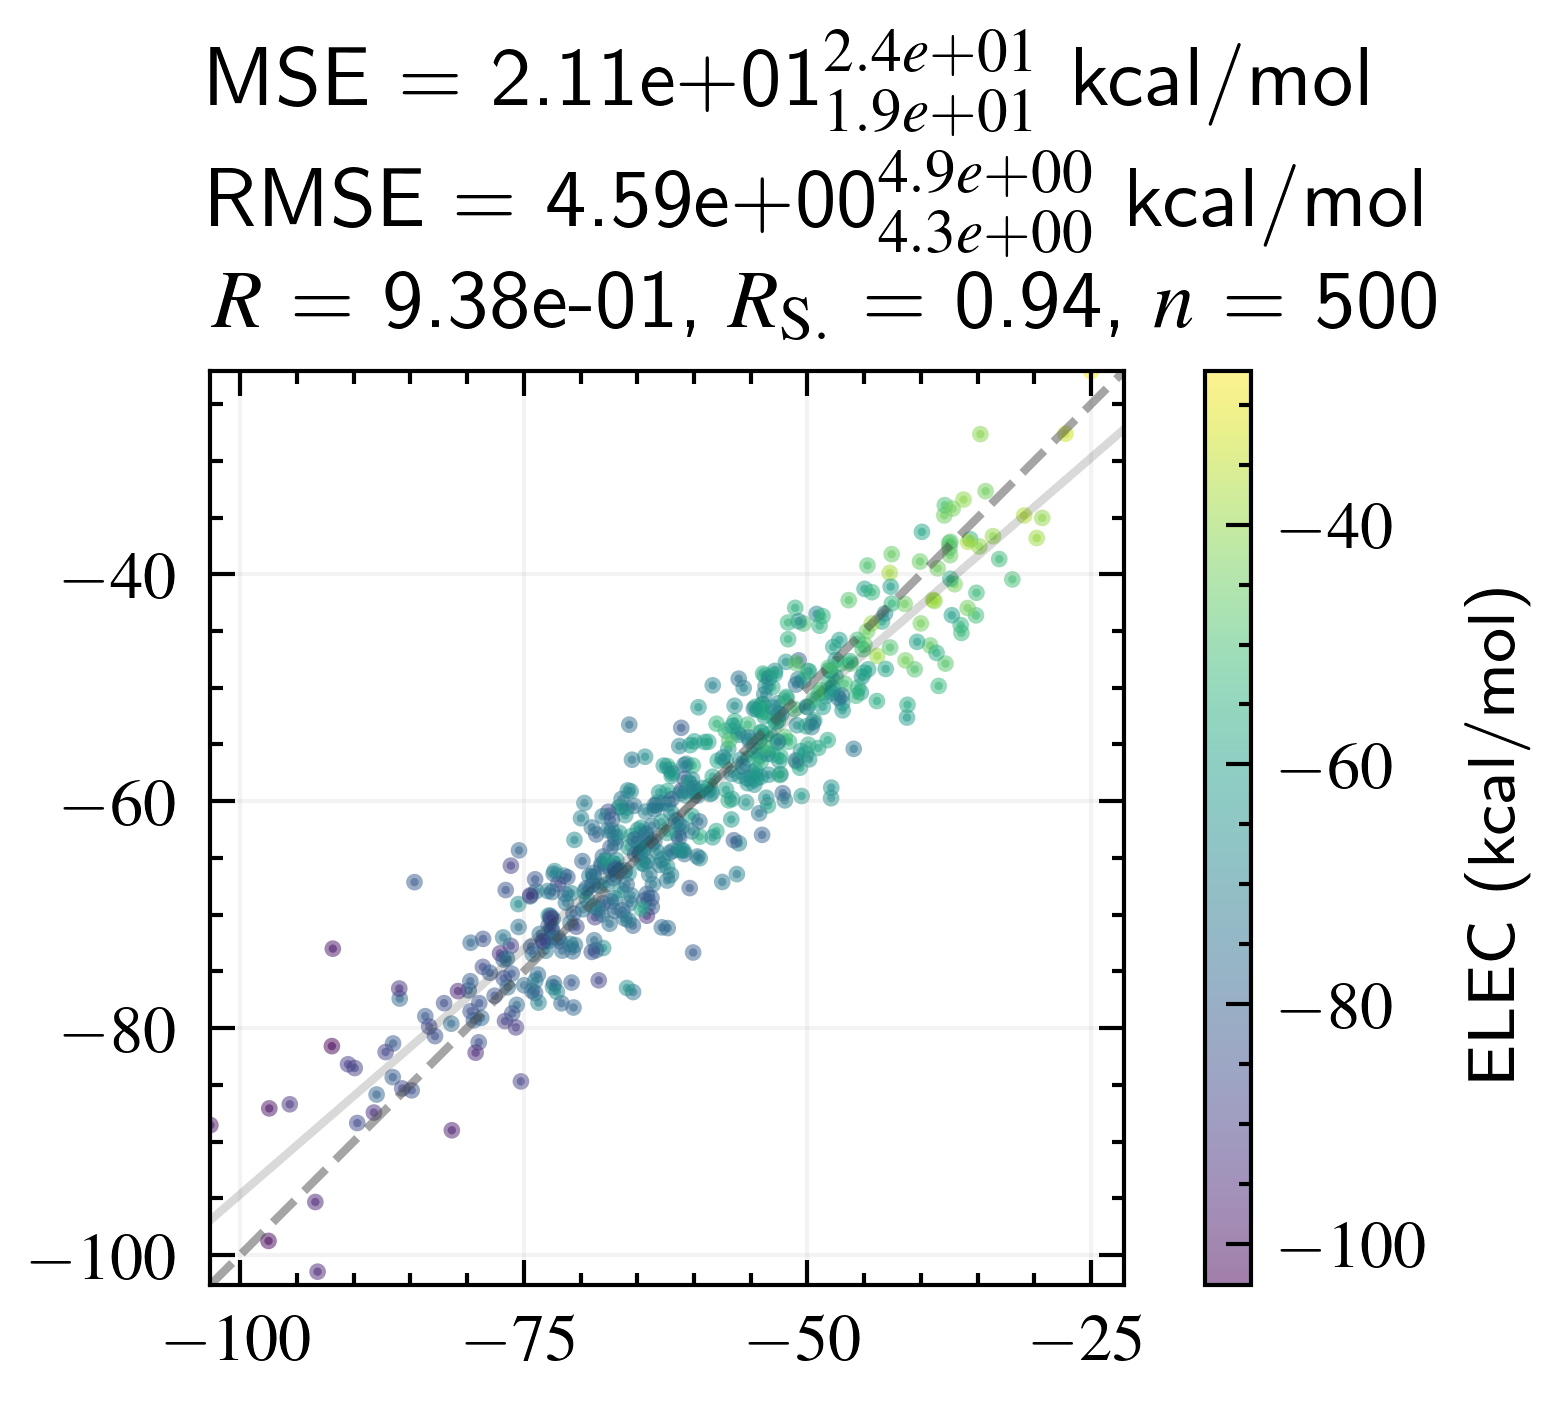

In [56]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("ecol_exact_lj_fit.pdf")


#  LJ fit exact, ECOL fit


In [57]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [58]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [59]:
# data_.data

In [60]:
# data_.monomer_df

In [61]:
# LJFF.data

In [62]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

71.26347


FF: LJ water_cluster fit_ECOL Exact intE (jax_coloumb: True)

In [63]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [64]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
8,179.096420,605,1053,0,True,Optimization terminated successfully.,"[0.001, 2.4999962974780323, 0.001, 0.003918207...","([[0.001, 2.4999962974780323, 0.001, 0.0039182..."
9,179.096436,743,1292,0,True,Optimization terminated successfully.,"[0.001, 2.5, 0.001, 0.003918060288196129]","([[0.001, 2.5, 0.001, 0.003918060288196129], [..."
2,179.320816,644,1095,0,True,Optimization terminated successfully.,"[0.001, 2.5, 0.014263139481585923, 0.003783709...","([[0.001, 2.5, 0.014263139481585923, 0.0037837..."
3,180.308441,392,716,0,True,Optimization terminated successfully.,"[0.4460411631447983, 2.3364278970391488, 0.001...","([[0.4460411631447983, 2.3364278970391488, 0.0..."
0,205.833069,91,275,0,True,Optimization terminated successfully.,"[1001.3579229369614, 1996.8292202356433, 1303....","([[1001.3579229369614, 1996.8292202356433, 130..."
7,209.231857,279,515,0,True,Optimization terminated successfully.,"[0.001, 2.151338909420952, 2.4591553274321285,...","([[0.001, 2.151338909420952, 2.459155327432128..."
4,209.613510,383,685,0,True,Optimization terminated successfully.,"[0.0010000200779059247, 2.1486203085849387, 2....","([[0.0010000200779059247, 2.1486203085849387, ..."
5,444.005432,321,564,0,True,Optimization terminated successfully.,"[1.7986775922891272, 0.8979771368870504, 0.001...","([[1.7986775922891272, 0.8979771368870504, 0.0..."
1,5448.363281,40,122,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.5, 2.5]","([[0.001, 0.001, 2.5, 2.5], [0.001, 0.001, 2.4..."
6,5448.363281,45,158,0,True,Optimization terminated successfully.,"[0.001, 0.02980885913927772, 0.969256095300102...","([[0.001, 0.02980885913927772, 0.9692560953001..."


In [65]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 2.49999630e+00, 1.00000000e-03, 3.91820716e-03])

In [66]:
abs(LJFF.eval_jax(bestres)).mean()

Array(71.0056, dtype=float32)

In [67]:
abs(LJFF.targets).mean()

Array(71.26347, dtype=float32)

In [68]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

13.382691070486755

2.404550344734395e-217


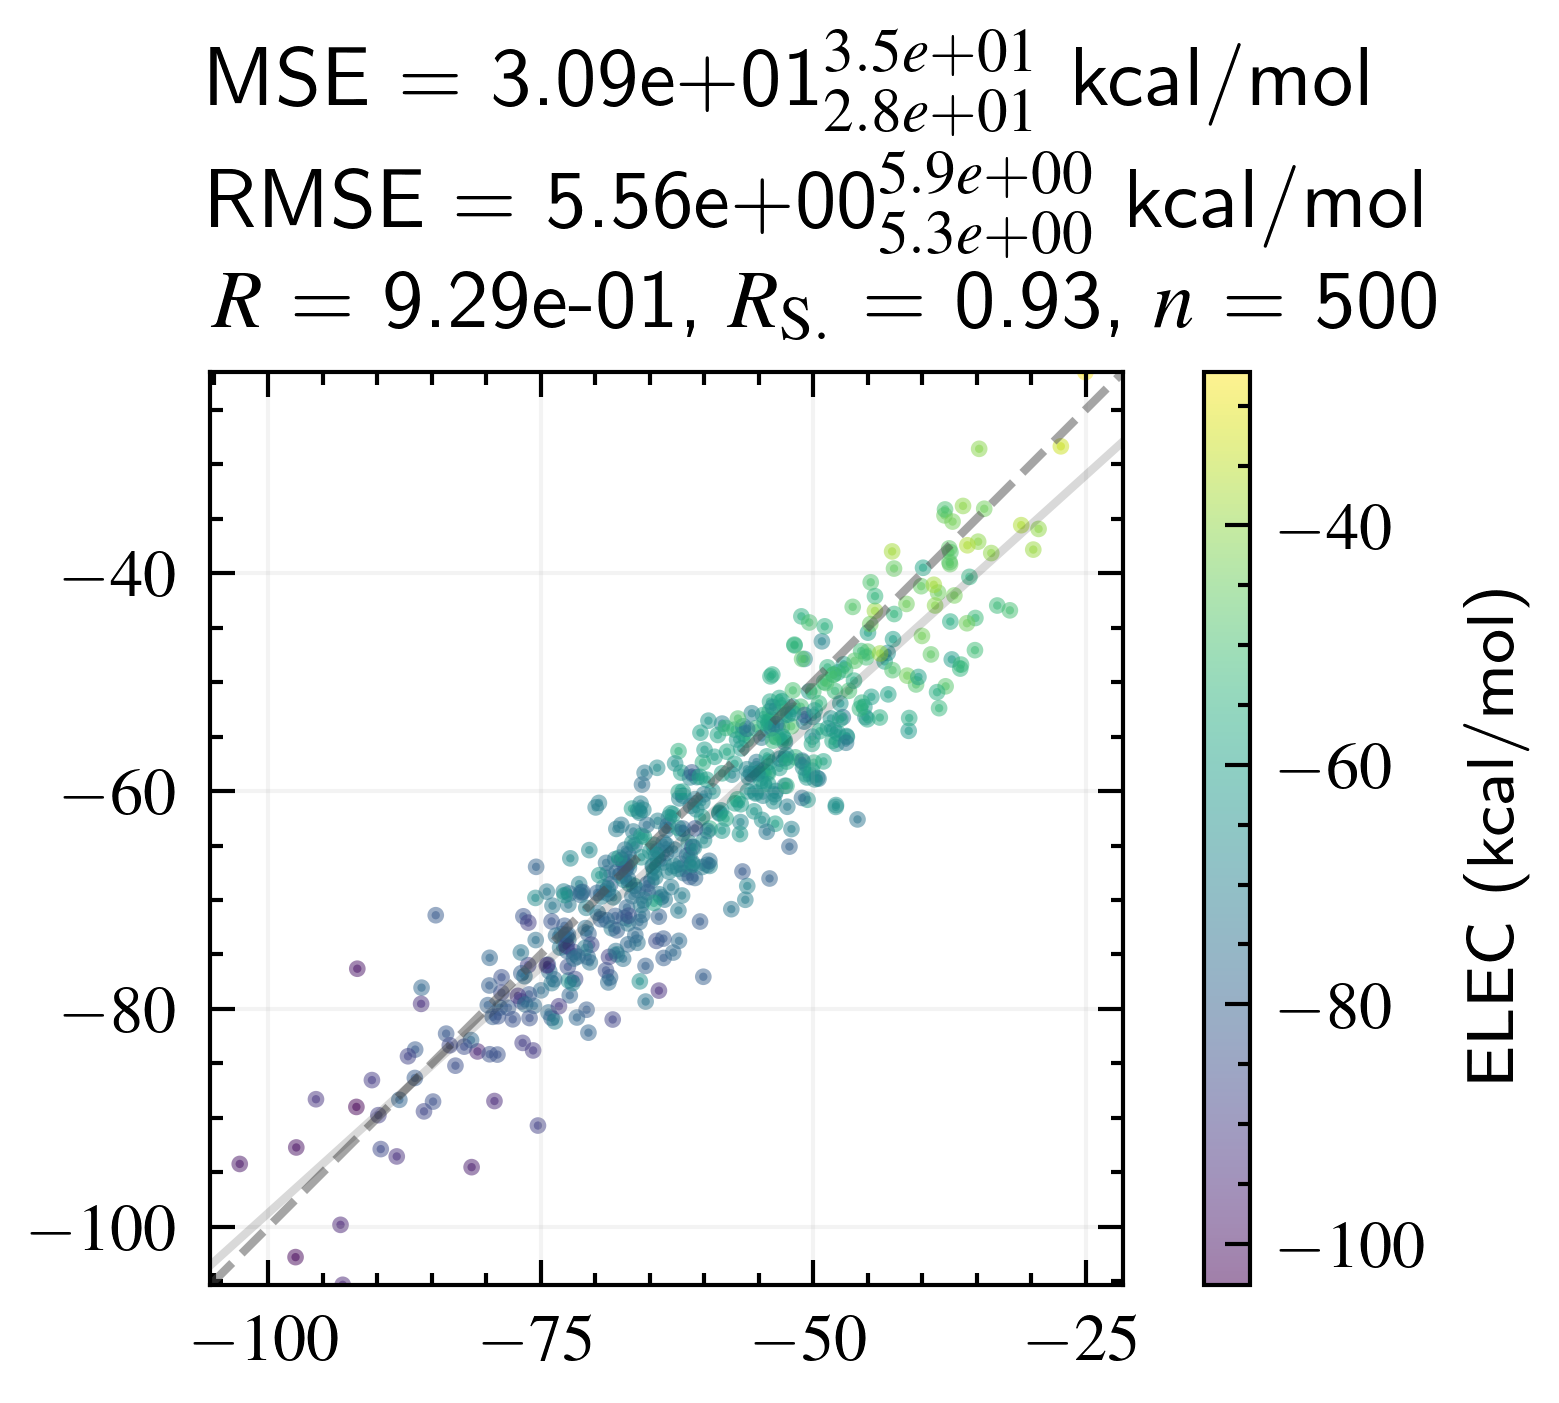

In [69]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("optpc_ecol_fit_exact_lj_fit.pdf")


#  LJ fit harmonic, ECOL fit


In [70]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_optpc_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [71]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [72]:
# data_.data

In [73]:
# data_.monomer_df

In [74]:
# LJFF.data

In [75]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "harmonic"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

72.35682


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [76]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [77]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
1,178.140106,680,1199,0,True,Optimization terminated successfully.,"[0.09079309420805537, 2.499998659406412, 0.001...","([[0.09079309420805537, 2.499998659406412, 0.0..."
2,178.148605,649,1099,0,True,Optimization terminated successfully.,"[0.001, 2.4999926575152323, 0.001, 0.003976256...","([[0.001, 2.4999926575152323, 0.001, 0.0039762..."
0,205.833069,91,275,0,True,Optimization terminated successfully.,"[1001.3579229369614, 1996.8292202356433, 1303....","([[1001.3579229369614, 1996.8292202356433, 130..."
3,1655.208984,198,368,0,True,Optimization terminated successfully.,"[2.0646406293577173, 0.0013875266391632133, 0....","([[2.0646406293577173, 0.0013875266391632133, ..."
4,5603.505371,42,143,0,True,Optimization terminated successfully.,"[0.037794943733553965, 0.001, 2.48536285577618...","([[0.037794943733553965, 0.001, 2.485362855776..."
5,5603.505371,42,149,0,True,Optimization terminated successfully.,"[0.001, 0.08192553767380864, 0.942686537897848...","([[0.001, 0.08192553767380864, 0.9426865378978..."
6,5603.505371,62,187,0,True,Optimization terminated successfully.,"[0.001, 0.115395954230535, 1.2522457828167974,...","([[0.001, 0.115395954230535, 1.252245782816797..."
7,5603.505371,38,147,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.055641854425555, 2.5]","([[0.001, 0.001, 2.055641854425555, 2.5], [0.0..."
8,5603.505371,57,170,0,True,Optimization terminated successfully.,"[0.11767986968059652, 0.001, 0.001, 2.11213211...","([[0.11767986968059652, 0.001, 0.001, 2.112132..."
9,5603.505371,61,180,0,True,Optimization terminated successfully.,"[0.001, 0.04346708907466079, 2.5, 1.7599569287...","([[0.001, 0.04346708907466079, 2.5, 1.75995692..."


In [78]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([9.07930942e-02, 2.49999866e+00, 1.00000000e-03, 3.94237540e-03])

In [79]:
abs(LJFF.eval_jax(bestres)).mean()

Array(72.04341, dtype=float32)

In [80]:
abs(LJFF.targets).mean()

Array(72.35682, dtype=float32)

In [81]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

13.346913733188353

3.8168207373222414e-222


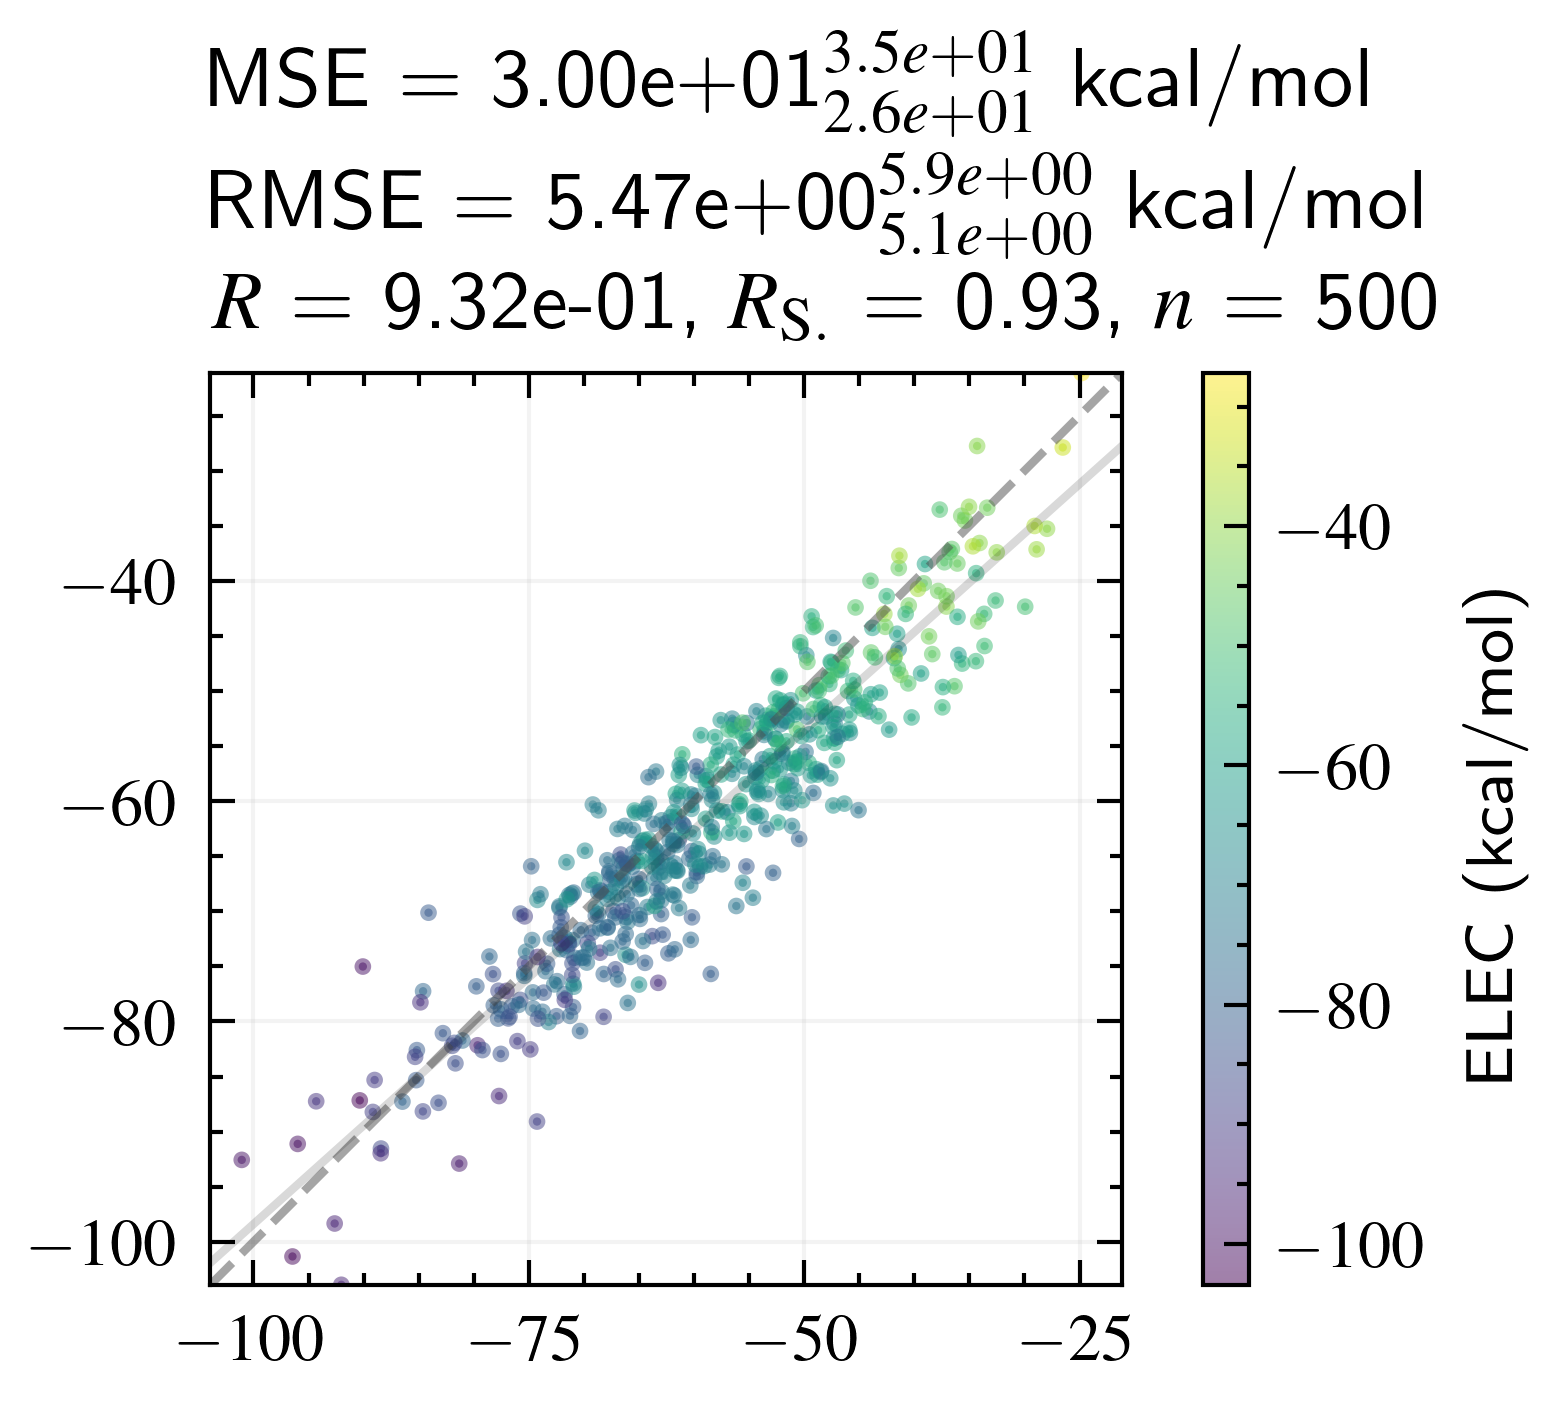

In [82]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("optpc_ecol_fit_harmonic_lj_fit.pdf")


#  DE fit


In [23]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF.data.intE.abs().mean()

59.12803914354881

In [24]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [30]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,11.775151,964,1559,0,True,Optimization terminated successfully.,"[0.3411363344649736, 1.2834539826299567, 2.5, ...","([[0.3411363344649736, 1.2834539826299567, 2.5..."
11,11.775182,596,1013,0,True,Optimization terminated successfully.,"[0.3410279489227199, 1.2835442577247882, 2.499...","([[0.3410279489227199, 1.2835442577247882, 2.4..."
6,11.775245,1476,2327,0,True,Optimization terminated successfully.,"[0.34114571204260147, 1.283410496813493, 2.499...","([[0.34114571204260147, 1.283410496813493, 2.4..."
20,11.775511,1283,2046,0,True,Optimization terminated successfully.,"[0.3406634610028251, 1.2834286543030644, 2.499...","([[0.3406634610028251, 1.2834286543030644, 2.4..."
9,11.776557,581,946,0,True,Optimization terminated successfully.,"[0.3407296851411241, 1.2837287936298885, 2.499...","([[0.3407296851411241, 1.2837287936298885, 2.4..."
17,11.777202,943,1549,0,True,Optimization terminated successfully.,"[0.34070603589209786, 1.2838674274856148, 2.49...","([[0.34070603589209786, 1.2838674274856148, 2...."
1,11.792897,1024,1623,0,True,Optimization terminated successfully.,"[0.3391777333651863, 1.2858844652607933, 2.499...","([[0.3391777333651863, 1.2858844652607933, 2.4..."
16,11.793501,729,1197,0,True,Optimization terminated successfully.,"[0.3392183785149385, 1.2858566511837575, 2.499...","([[0.3392183785149385, 1.2858566511837575, 2.4..."
8,11.793520,1672,2621,0,True,Optimization terminated successfully.,"[0.33895459035051223, 1.2859510668931469, 2.49...","([[0.33895459035051223, 1.2859510668931469, 2...."
18,14.313481,740,1191,0,True,Optimization terminated successfully.,"[0.4379737380241687, 1.1385457267294805, 2.5, ...","([[0.4379737380241687, 1.1385457267294805, 2.5..."


In [27]:
# np.sqrt(10.7)

In [28]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.4314940263311815

/home/boittier/miniconda3/envs/pycharmm/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


2.0136656937969305e-19


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 1.2343012918828257e+76,
  'RMSE': 1.110991130424913e+38,
  'R': -0.38811610661346574,
  'RS': -0.3537352069408277,
  'n': 500,
  'slope': -9.093174018307893e+35,
  'intercept': inf})

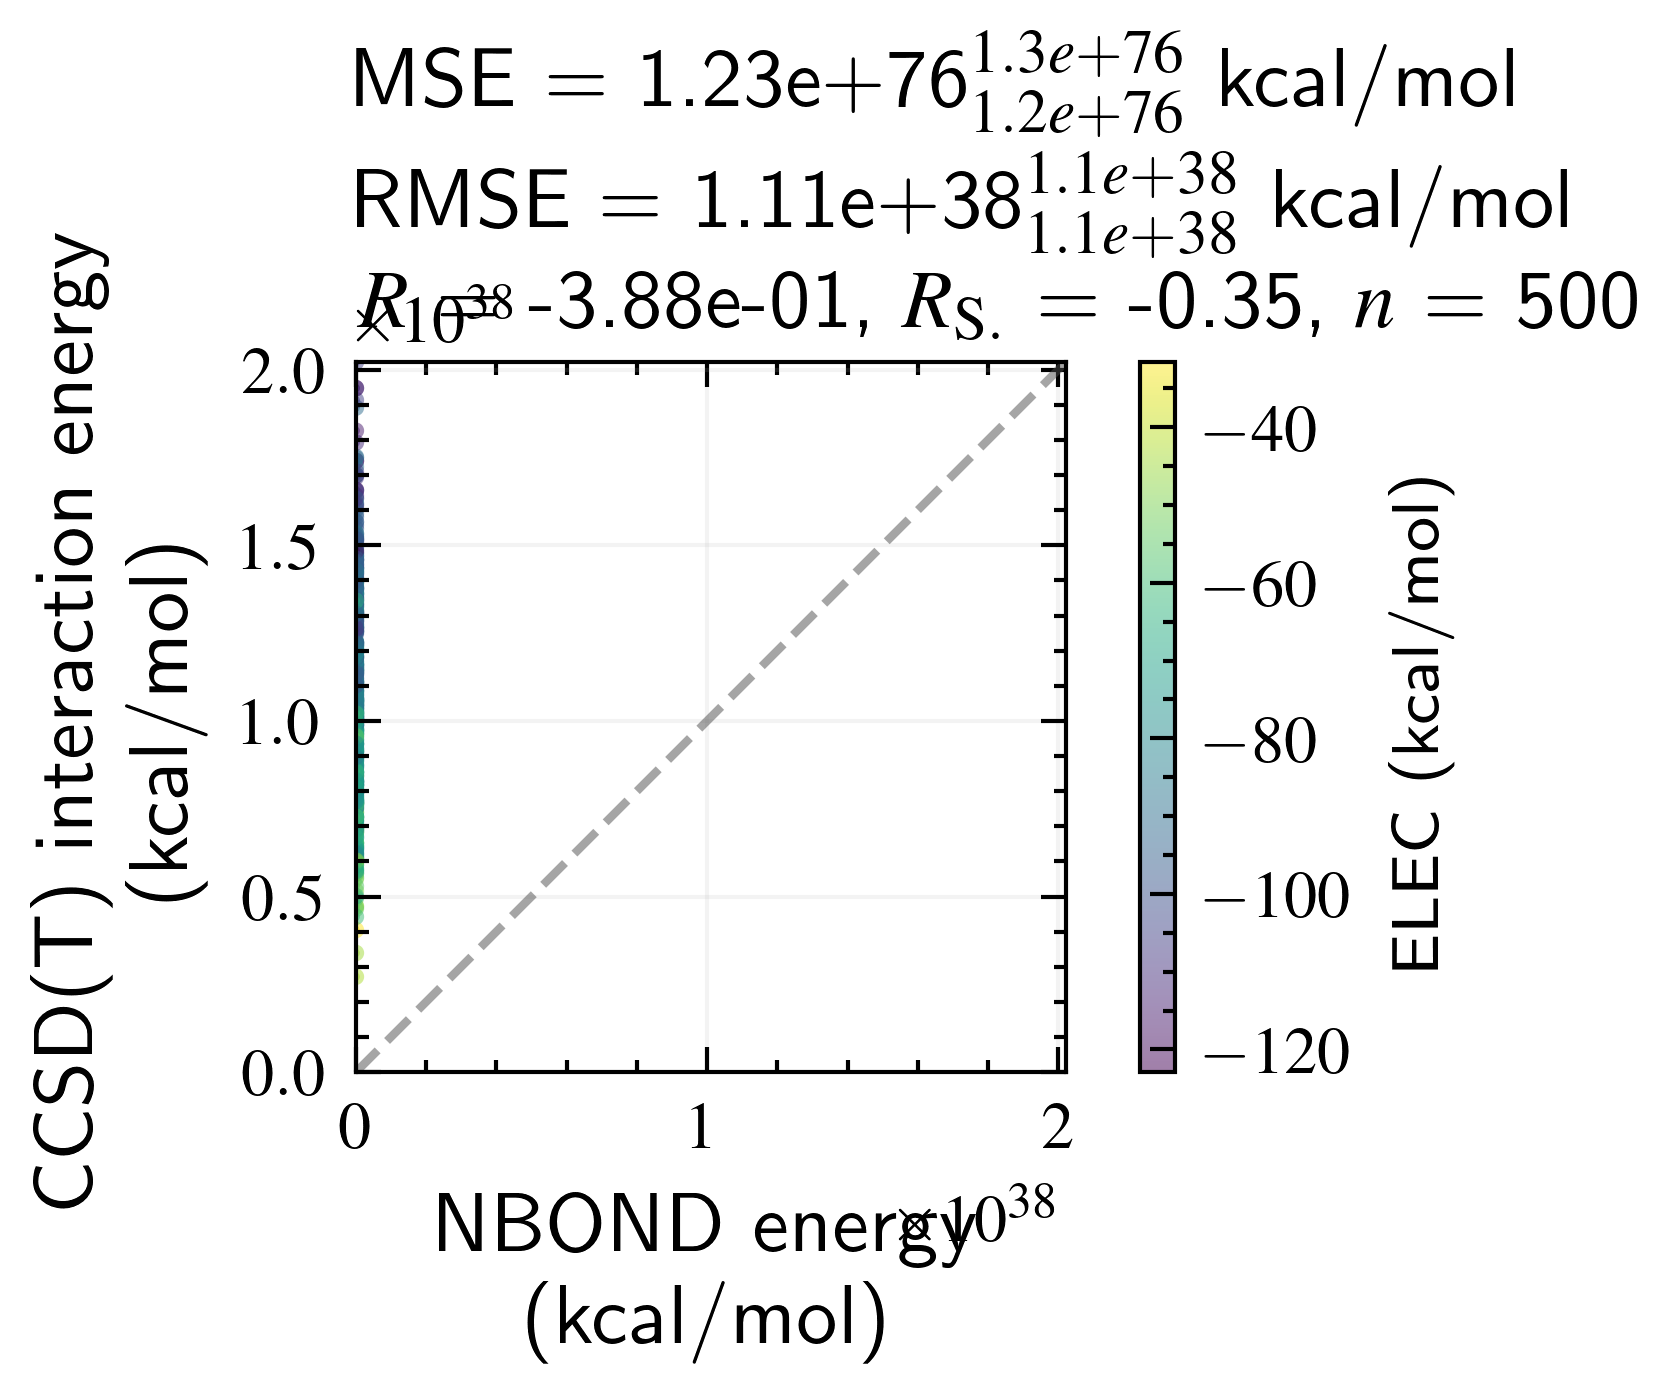

In [63]:
LJFF.data["fit_intE"] = LJFF.eval_jax(resx) + LJFF.data.ELEC

plot_energy_MSE(DEFF.data, "intE", "fit_intE",  elec = "ELEC")



In [27]:
resx = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").x)[0]

(array([  7.,  27.,  43.,  79., 100., 111.,  64.,  50.,  13.,   6.]),
 array([-77.66558075, -72.58831787, -67.51104736, -62.43378067,
        -57.35651779, -52.2792511 , -47.20198441, -42.12471771,
        -37.04745102, -31.97018623, -26.89291954]),
 <BarContainer object of 10 artists>)

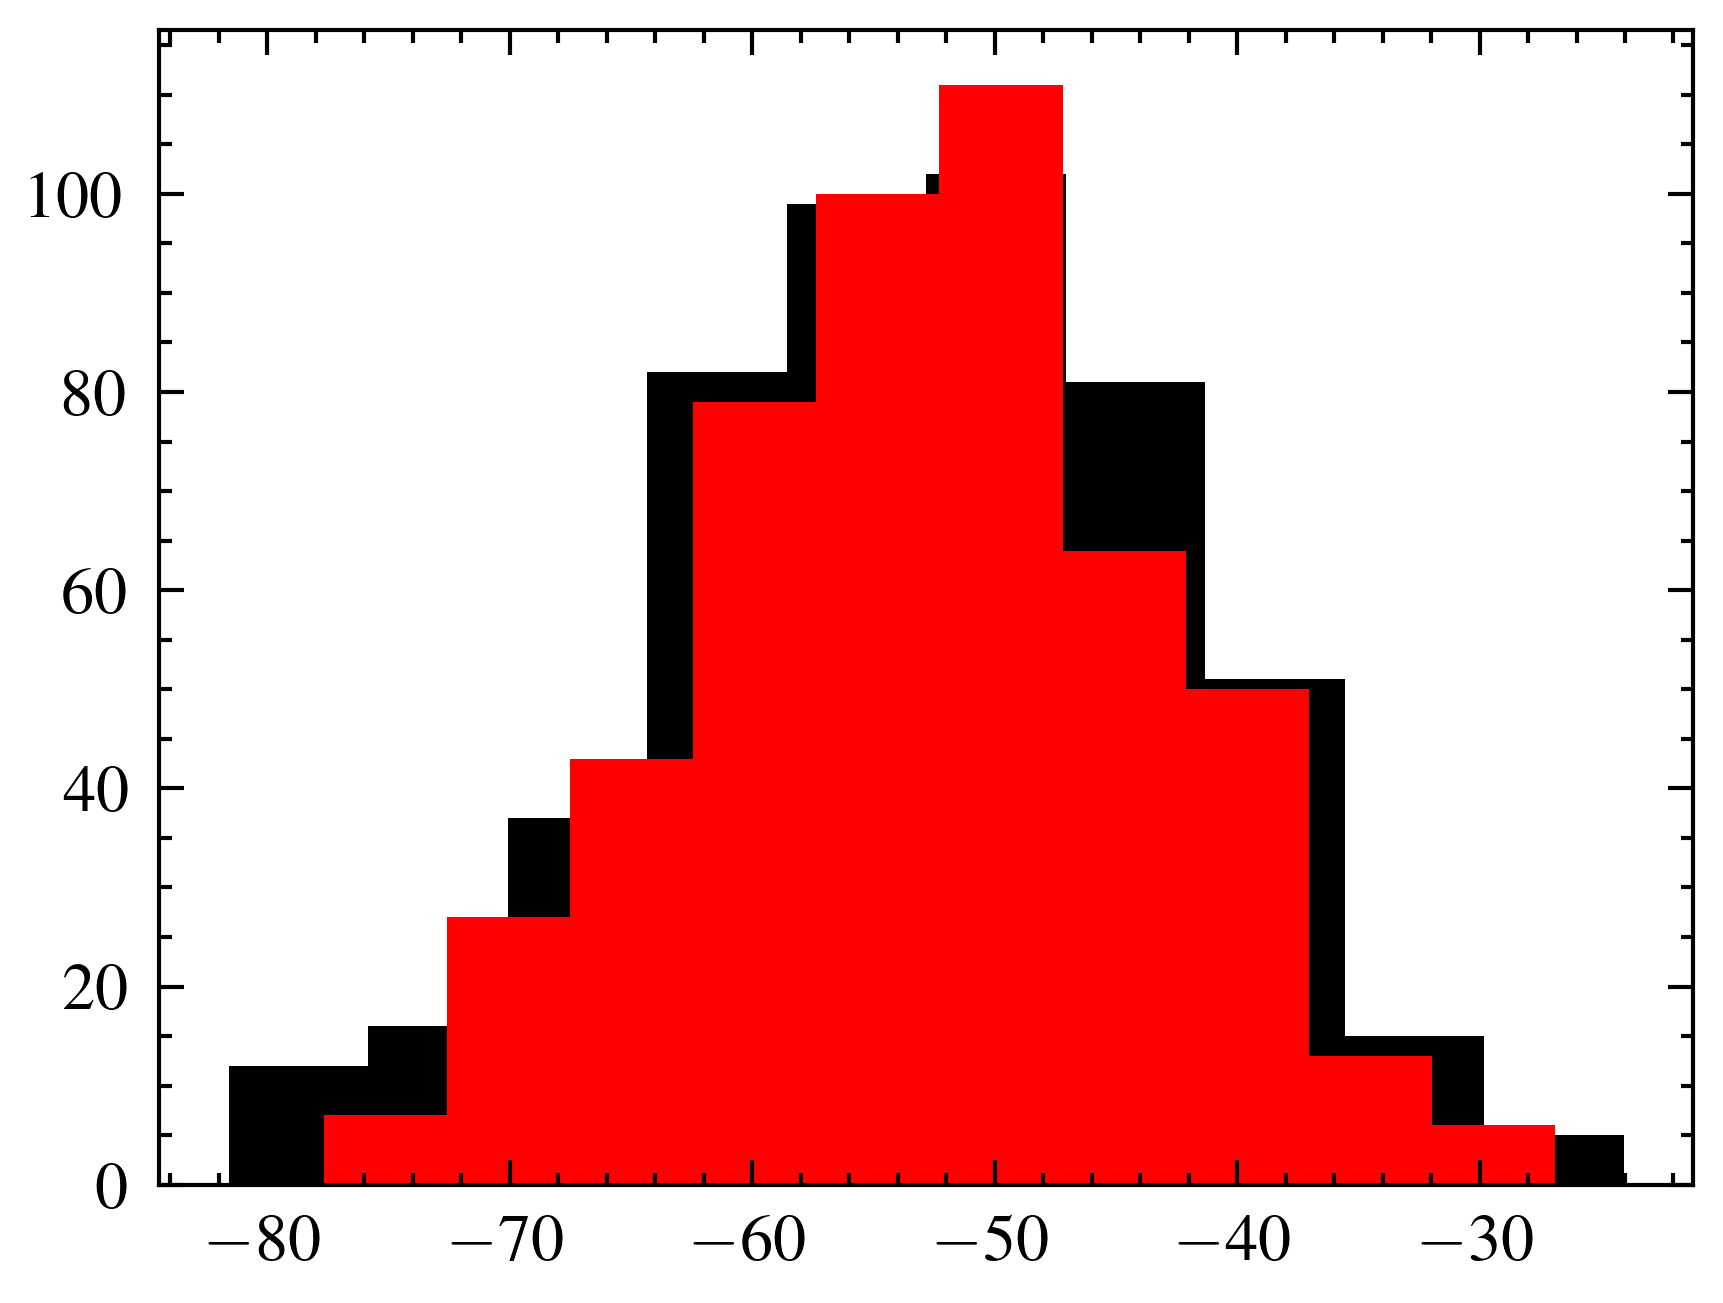

In [32]:
plt.hist(DEFF.targets)
plt.hist(DEFF.eval_jax_de(resx))

In [30]:
resx

array([ 0.34116161,  1.28335808,  2.5       ,  2.49999817,  7.37977031,
       19.28580408])

0.0


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 11.775170940231728,
  'RMSE': 3.431496894976262,
  'R': 0.9907021031578068,
  'RS': 0.9895893343573374,
  'n': 500,
  'slope': 0.9575077841699374,
  'intercept': -5.660148647068695})

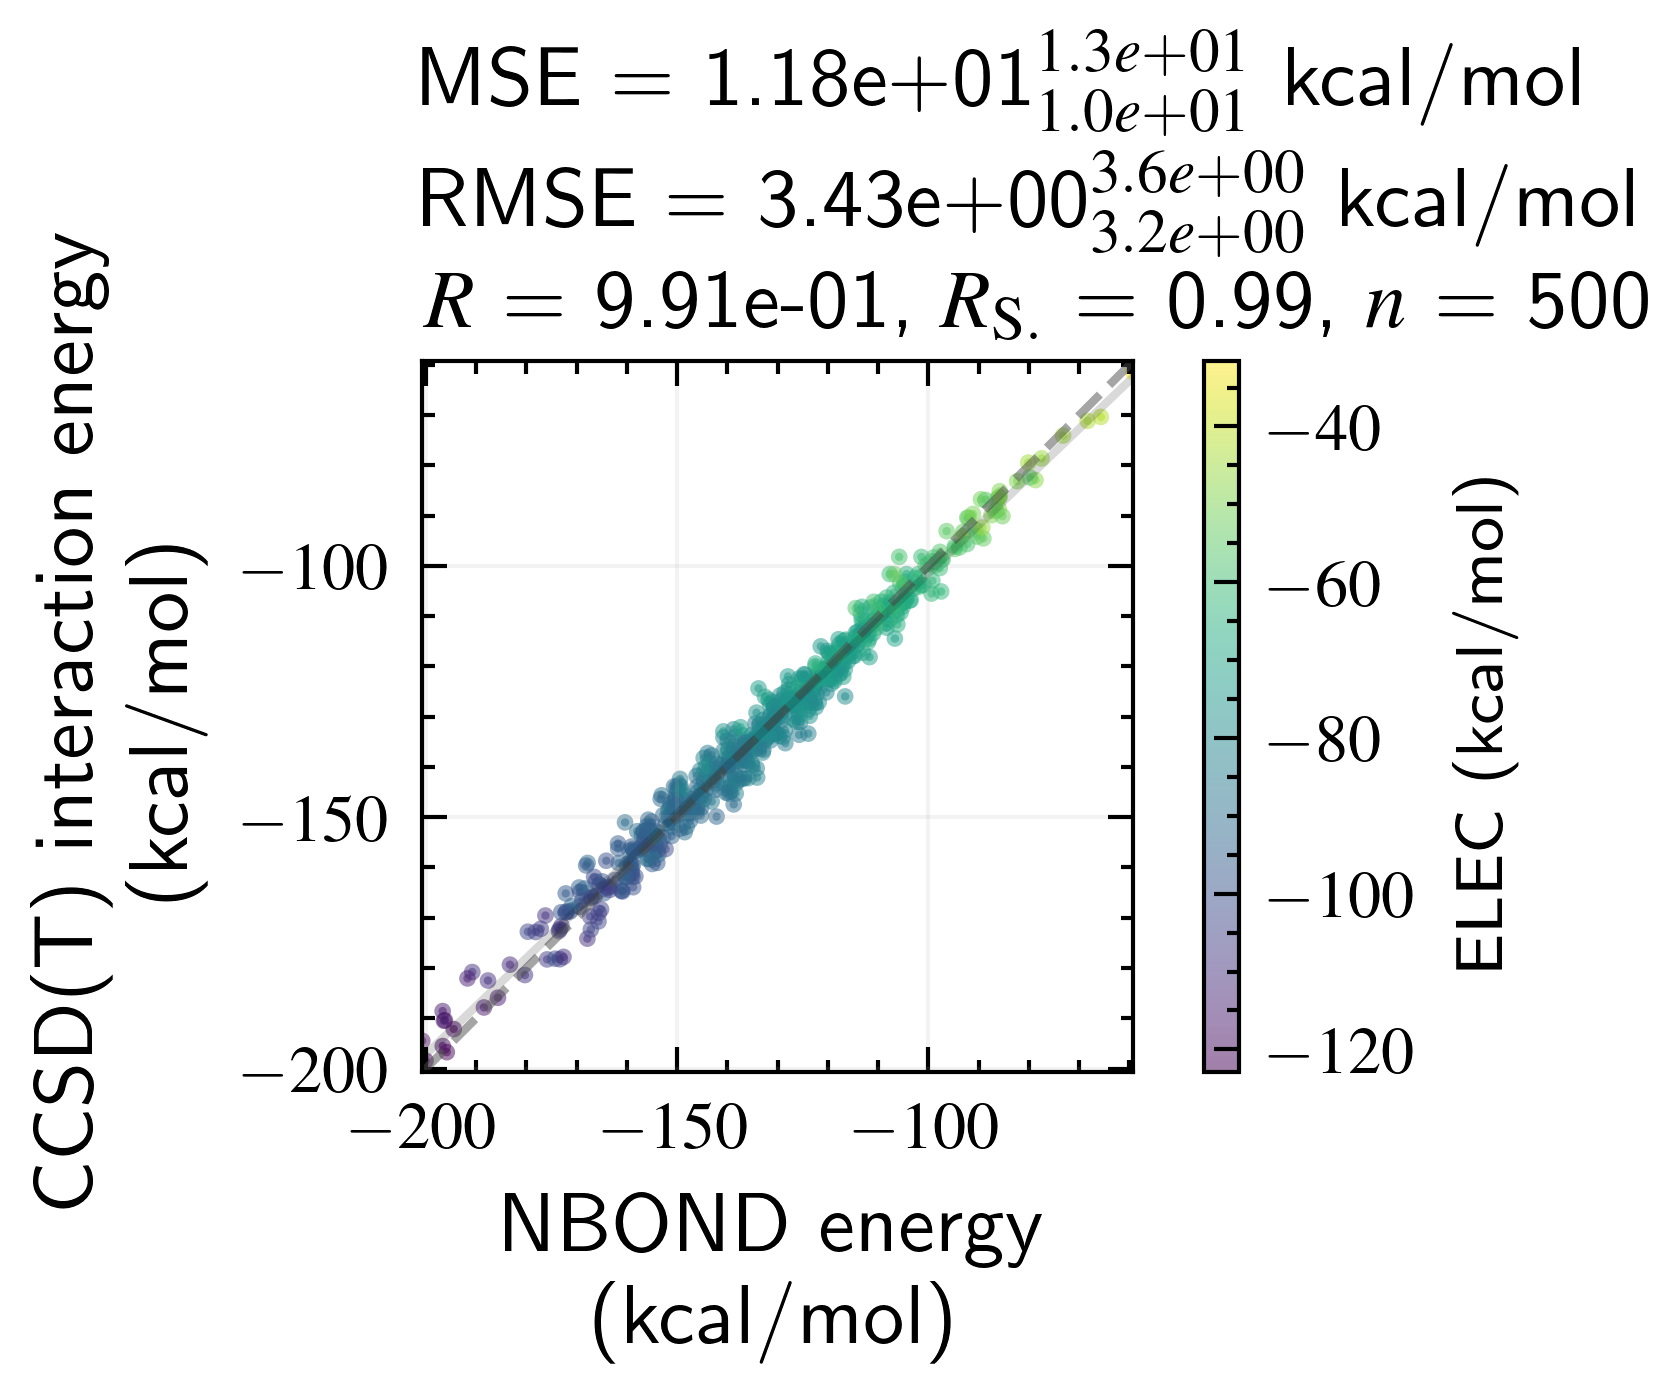

In [31]:
DEFF.data["fit_ECOL_"] = DEFF.eval_jax_de(resx) + _c.data.ELEC

plot_energy_MSE(DEFF.data, "ECOL", "fit_ECOL_",  elec = "ELEC")

